# Pipeline

1. Preprocessing
2. Cosine Similarity / Nearest Neighbors
3. Scale / Standardize
4. Build / Test Models

## 1. Preprocessing

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [23]:
# read in data 
db_path = '../data/beer.db'
conn = sqlite3.connect(db_path)

query = "SELECT * FROM user_extract"
df = pd.read_sql(query, conn)

a. remove duplicates 

In [24]:
df = df[~df.duplicated()]

b. one-hot encode categorical variables

In [25]:
categorical_variables = ['beer_description', 'brewery']
for cat_var in categorical_variables:
    dummies = pd.get_dummies(df[cat_var], drop_first=True, prefix=cat_var)
    df = pd.merge(df, dummies, left_index=True, right_index=True)

c. flag outliers

In [27]:
df['IBU'] = df['IBU'].astype(float)

In [28]:
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
skipnas = True

for feature in features:
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    iqr = q3 - q1
    non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
    outliers = df[~non_outlier_mask]

    print("FEATURE {}".format(feature))
    print("num of outliers = {:,d}".format(len(outliers)))
    print("% of outliers = {:.2f}%".format(100*len(outliers)/len(df)))
    print("\n")

FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


FEATURE global_rating
num of outliers = 3,648
% of outliers = 3.56%


FEATURE user_rating
num of outliers = 11,267
% of outliers = 10.98%


FEATURE IBU
num of outliers = 47,592
% of outliers = 46.39%




In [31]:
df.iloc[:,:8].isna().sum()

username                0
beer_name               0
beer_description        0
brewery                 0
ABV                   923
IBU                 47035
global_rating           0
user_rating          3882
dtype: int64

d. Impute missing values

In [32]:
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
impute_method = 'mean'

for feature in features:
    if impute_method == 'mean':
        non_nas = df[~df[feature].isna()][feature].astype(float)
        feature_mean = non_nas.mean()
        df[feature] = df[feature].fillna(feature_mean)

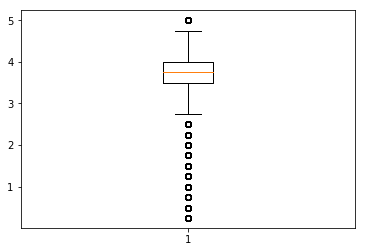

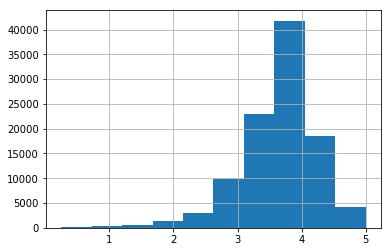

In [33]:
plt.boxplot(df['user_rating'])
plt.show()
df['user_rating'].hist()

In [34]:
df.iloc[:,:8].isna().sum()

username            0
beer_name           0
beer_description    0
brewery             0
ABV                 0
IBU                 0
global_rating       0
user_rating         0
dtype: int64

In [37]:
df.iloc[:,:8].dtypes

username             object
beer_name            object
beer_description     object
brewery              object
ABV                 float64
IBU                 float64
global_rating       float64
user_rating         float64
dtype: object

Take another look at 'user_rating' outliers after imputation

In [38]:
features = ['ABV', 'global_rating', 'user_rating', 'IBU']

for feature in features:
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    iqr = q3 - q1
    non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
    outliers = df[~non_outlier_mask]

    print("FEATURE {}".format(feature))
    print("num of outliers = {:,d}".format(len(outliers)))
    print("% of outliers = {:.2f}%".format(100*len(outliers)/len(df)))
    print("\n")

FEATURE ABV
num of outliers = 2,498
% of outliers = 2.43%


FEATURE global_rating
num of outliers = 3,648
% of outliers = 3.56%


FEATURE user_rating
num of outliers = 7,385
% of outliers = 7.20%


FEATURE IBU
num of outliers = 29,041
% of outliers = 28.31%




## 2. Cosine Similarity / Nearest Neighbors

a. Create User-Item Matrix 

In [39]:
# User Specified Fill Method
fill_method = 0

In [40]:
# Create User-Item Matrix 
data = df
values = 'user_rating'
index = 'username'
columns = 'beer_name'
agg_func = 'mean'

if fill_method == 'item_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix = ui_matrix.fillna(ui_matrix.mean(axis=0), axis=0)

elif fill_method == 'user_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

elif fill_method == 0:
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func, fill_value=0)
else:
    raise ValueError("Please checkout 'fill_method' value")

ui_matrix.columns = list(ui_matrix.columns)

ui_matrix.head()

,!Wild Blend! (Morango+Amora),"""33"" Export","""Body"" System","""British Bitter"" English Pale Ale","""Calcium"" Blood Orange","""Craft Beer"" Dark Lager Dry Hopped Oct. 2017","""Cream Soda"" Wheat IPA","""Cult of Pekko"" Hop-Scotch IPA (2017)","""K"" is for Kriek","""Not Just Some"" Oatmeal Stout",...,分 桃 (Fēn Táo),分 桃 (Fēn Táo) (Blend 2),废都 (Two Lost Capitals),日本から来たネコ (Some Cat From Japan),日本で人気がある Big In Japan DDH IPA,木島平村 Hard Cider #39,藻細工S-IPA (mosaic S-IPA),調和,黄雪 (おうせき) - Yellow Snow,광화문 Seoulite Ale
username,,,,,,,,,,,,,,,,,,,,,
AFernan25,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
AlexKress,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Asier05,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Audyoh,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Boat,4,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0


c. Calculate Cosine Similarity

In [41]:
# Calculate Cosine Similarity 
user_of_reference = 'tsharp93'
print("User of Reference for Cosine Sim = {}".format(user_of_reference))

from sklearn.metrics.pairwise import cosine_similarity
X = ui_matrix[ui_matrix.index == user_of_reference]
Y = ui_matrix[ui_matrix.index != user_of_reference]

sim = cosine_similarity(X,Y)[0].tolist()
names = Y.index

sim_df = pd.DataFrame({'username':names, 'sim_score':sim})
sim_df = sim_df.sort_values(by='sim_score', ascending=False)

User of Reference for Cosine Sim = tsharp93


In [42]:
sim_df.head()

,username,sim_score
110,r4ymond,0.059821
82,edufontanez,0.054202
0,AFernan25,0.051696
15,FernandoRamirez,0.049640
103,mikeyjimenez,0.048229


d. Add Nearest Neighbor (Cosine Sim) Rank to Data

In [43]:
# add neighbor rank to df
neighbor_rank = sim_df.reset_index(drop=True)
neighbor_rank.index.name = 'nearest_neighbor_rank'
neighbor_rank.reset_index(inplace=True)
neighbor_rank['nearest_neighbor_rank'] = neighbor_rank['nearest_neighbor_rank'] + 1
neighbor_rank = neighbor_rank[['nearest_neighbor_rank', 'username']]

In [44]:
neighbor_rank.head()

,nearest_neighbor_rank,username
0,1,r4ymond
1,2,edufontanez
2,3,AFernan25
3,4,FernandoRamirez
4,5,mikeyjimenez


In [45]:
print(df.shape)
df = pd.merge(neighbor_rank, df, on='username', how='outer')
print(df.shape)

(102598, 8347)
(102598, 8348)


In [46]:
df[df['username'] == 'tsharp93'].head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating,first_date,...,brewery_Токсовская Сидрерия (On The Bones),brewery_Тощий Заяц,brewery_Уманьпиво,brewery_Ферментстейшн,brewery_Фонтан / Кваспром,brewery_Хадыженский Пивзавод,brewery_Хмельной Патрик,brewery_Частная пивоварня Joker,brewery_Чисто пивоварня,brewery_Южный пивовар
102558,NaN,tsharp93,Firestone Lager,Lager - Helles,Firestone Walker Brewing Company,4.5,17.0,3.58,3.50,06/23/19,...,0,0,0,0,0,0,0,0,0,0
102559,NaN,tsharp93,Köstritzer Schwarzbier,Schwarzbier,Köstritzer Schwarzbierbrauerei,4.8,22.0,3.53,3.25,06/11/19,...,0,0,0,0,0,0,0,0,0,0
102560,NaN,tsharp93,Midas Touch,Gruit / Ancient Herbed Ale,Dogfish Head Craft Brewery,9.0,12.0,3.78,3.25,06/01/19,...,0,0,0,0,0,0,0,0,0,0
102561,NaN,tsharp93,Twisted Monkey,Belgian Blonde,Victory Brewing Company,5.8,15.0,3.46,4.00,06/01/19,...,0,0,0,0,0,0,0,0,0,0
102562,NaN,tsharp93,Fresh Squeezed IPA,IPA - American,Deschutes Brewery,6.4,60.0,3.94,4.25,05/21/19,...,0,0,0,0,0,0,0,0,0,0


## 3. Scale / Standardize Data 

#### Select Features and Target

In [47]:
brewery_cols = [col for col in df if col.startswith('brewery_')]
beer_description_cols = [col for col in df if col.startswith('beer_description_')]

features = ['ABV', 'IBU', 'global_rating'] + beer_description_cols
target = 'user_rating'

print("REMINDER User of Reference = {}".format(user_of_reference))

REMINDER User of Reference = tsharp93


#### Transform Features and Target Separately (easier to Inverse Transform later)

In [48]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(df[features])
df[features] = X_scaler.transform(df[features])

y_scaler = StandardScaler()
y = np.array(df[target]).reshape(-1, 1 )
y_scaler.fit(y)
df[target] = y_scaler.transform(y)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


## 4. Build Models

In [49]:
rand_state = 10

### B. Take Top Nearest Neighbors

In [21]:
n_users_list = range(5,11)

for n in n_users_list:
    top_n = list(sim_df.sort_values('sim_score', ascending=False)[0:n]['username'])
    top_n_df = df[df['username'].isin(top_n)]
    print("N = {}, # Points = {:,d}".format(n, len(top_n_df)))

N = 5, # Points = 1,175
N = 6, # Points = 1,375
N = 7, # Points = 1,450
N = 8, # Points = 3,750
N = 9, # Points = 5,125
N = 10, # Points = 7,700


#### Lasso, Search for Alpha

In [22]:
mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []

for top_n in n_users_list:
    
    # split data 
    df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
    X_train = df_top_n[features]
    y_train = df_top_n[target]
    
    X_test = df[df['username'] == user_of_reference][features]
    y_test = df[df['username'] == user_of_reference][target]

    # train
    from sklearn.linear_model import LassoCV
    model = LassoCV(fit_intercept=False, normalize=False, cv=5, random_state=rand_state)
    model.fit(X_train, y_train)

    # Evaluate model on user's data 
    preds = model.predict(X_test)

    # unscale
    preds_unscaled = y_scaler.inverse_transform(preds)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # evaluate results
    results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
    results_df.columns = ['predicted', 'actual']
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = abs(results_df['error'])

    # Performance Metrics 
    mae = np.mean(results_df['abs_error'])
    print('MAE =', np.round(mae, 5), "for n =", top_n, 
          "with alpha =", np.round(model.alpha_, 5))

    quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
    half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
    mae_list.append(mae)

MAE = 0.38225 for n = 5 with alpha = 0.0409
MAE = 0.38331 for n = 6 with alpha = 0.02664
MAE = 0.37284 for n = 7 with alpha = 0.02353
MAE = 0.3762 for n = 8 with alpha = 0.01941
MAE = 0.3751 for n = 9 with alpha = 0.01236
MAE = 0.37668 for n = 10 with alpha = 0.0108


#### ElasticNet, Search for Alpha, L1 Ratio = 0.5

In [23]:
mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []

for top_n in n_users_list:
    
    # split data 
    df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
    X_train = df_top_n[features]
    y_train = df_top_n[target]
    
    X_test = df[df['username'] == user_of_reference][features]
    y_test = df[df['username'] == user_of_reference][target]

    # train
    from sklearn.linear_model import ElasticNetCV
    model = ElasticNetCV(fit_intercept=False, normalize=False, cv=5, random_state=rand_state)
    model.fit(X_train, y_train)

    # Evaluate model on user's data 
    preds = model.predict(X_test)

    # unscale
    preds_unscaled = y_scaler.inverse_transform(preds)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # evaluate results
    results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
    results_df.columns = ['predicted', 'actual']
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = abs(results_df['error'])

    # Performance Metrics 
    mae = np.mean(results_df['abs_error'])
    print('MAE =', np.round(mae,5), "for n =", top_n, 
          "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)

    quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
    half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
    mae_list.append(mae)

MAE = 0.38198 for n = 5 with alpha = 0.07629 and l1 ratio =  0.5
MAE = 0.38399 for n = 6 with alpha = 0.04969 and l1 ratio =  0.5
MAE = 0.37297 for n = 7 with alpha = 0.04706 and l1 ratio =  0.5
MAE = 0.37664 for n = 8 with alpha = 0.03882 and l1 ratio =  0.5
MAE = 0.37511 for n = 9 with alpha = 0.02473 and l1 ratio =  0.5
MAE = 0.37674 for n = 10 with alpha = 0.02161 and l1 ratio =  0.5


#### SVR, C = 0.5, Epsilon = 0.25

In [24]:
eps = 0.25

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []

for top_n in n_users_list:
    
    # split data 
    df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
    X_train = df_top_n[features]
    y_train = df_top_n[target]
    
    X_test = df[df['username'] == user_of_reference][features]
    y_test = df[df['username'] == user_of_reference][target]

    # train
    from sklearn.svm import SVR
    for C in [0.5]:
        model = SVR(kernel='linear', epsilon=eps, C=C)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])
        print('MAE =', np.round(mae,5), "for n =", top_n, 
              "with C =", model.C, "and epsilon =", model.epsilon)

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

MAE = 0.38731 for n = 5 with C = 0.5 and epsilon = 0.25
MAE = 0.39794 for n = 6 with C = 0.5 and epsilon = 0.25
MAE = 0.39201 for n = 7 with C = 0.5 and epsilon = 0.25
MAE = 0.39195 for n = 8 with C = 0.5 and epsilon = 0.25
MAE = 0.36879 for n = 9 with C = 0.5 and epsilon = 0.25
MAE = 0.36558 for n = 10 with C = 0.5 and epsilon = 0.25


#### SVR, Search for C, Epsilon = 0.25

In [25]:
C_space = [0.1, 0.2, 0.5, 0.7, 1.0]

In [26]:
eps = 0.25

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []

for top_n in n_users_list:
    
    # split data 
    df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
    X_train = df_top_n[features]
    y_train = df_top_n[target]
    
    X_test = df[df['username'] == user_of_reference][features]
    y_test = df[df['username'] == user_of_reference][target]

    # train
    from sklearn.svm import SVR
    from sklearn.model_selection import GridSearchCV
    grid = {'C': C_space,
            'epsilon': [eps],
            'kernel':['linear']}
    svr = SVR()
    model = GridSearchCV(svr, param_grid=grid, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)

    # Evaluate model on user's data 
    preds = model.predict(X_test)

    # unscale
    preds_unscaled = y_scaler.inverse_transform(preds)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # evaluate results
    results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
    results_df.columns = ['predicted', 'actual']
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = abs(results_df['error'])

    # Performance Metrics 
    mae = np.mean(results_df['abs_error'])
    print('MAE =', np.round(mae,5), "for n =", top_n, 
          "with final params =", model.best_params_)

    quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
    half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
    mae_list.append(mae)

MAE = 0.38748 for n = 5 with final params = {'C': 0.2, 'epsilon': 0.25, 'kernel': 'linear'}
MAE = 0.39793 for n = 6 with final params = {'C': 0.1, 'epsilon': 0.25, 'kernel': 'linear'}
MAE = 0.3915 for n = 7 with final params = {'C': 0.1, 'epsilon': 0.25, 'kernel': 'linear'}
MAE = 0.39195 for n = 8 with final params = {'C': 0.5, 'epsilon': 0.25, 'kernel': 'linear'}
MAE = 0.36878 for n = 9 with final params = {'C': 0.1, 'epsilon': 0.25, 'kernel': 'linear'}
MAE = 0.36559 for n = 10 with final params = {'C': 0.7, 'epsilon': 0.25, 'kernel': 'linear'}


### Larger Top_N

In [41]:
len(df['username'].unique())

129

In [43]:
%%time

n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

for n in n_users_list:
    top_n = list(sim_df.sort_values('sim_score', ascending=False)[0:n]['username'])
    top_n_df = df[df['username'].isin(top_n)]
    print("N = {}, # Points = {:,d}".format(n, len(top_n_df)))

N = 5, # Points = 1,175
N = 10, # Points = 7,700
N = 15, # Points = 12,250
N = 20, # Points = 15,200
N = 25, # Points = 25,900
N = 30, # Points = 30,367
N = 35, # Points = 36,726
N = 40, # Points = 43,360
N = 45, # Points = 51,509
N = 50, # Points = 58,259
N = 55, # Points = 60,847
N = 60, # Points = 70,922
N = 65, # Points = 75,797
N = 70, # Points = 84,847
N = 75, # Points = 94,047
N = 80, # Points = 99,397
N = 85, # Points = 99,958
N = 100, # Points = 100,473
N = 128, # Points = 102,558
CPU times: user 17.9 s, sys: 12.9 s, total: 30.8 s
Wall time: 30.9 s


#### ElasticNet, Search for Alpha, Search for L1 Ratio

In [44]:
l1_ratio_space = [.1, .5, .7, .9, .95, .99, 1]

In [45]:
%%time

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []

for top_n in n_users_list:
    
    # split data 
    df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
    X_train = df_top_n[features]
    y_train = df_top_n[target]
    
    X_test = df[df['username'] == user_of_reference][features]
    y_test = df[df['username'] == user_of_reference][target]

    # train
    from sklearn.linear_model import ElasticNetCV
    model = ElasticNetCV(fit_intercept=False, normalize=False, l1_ratio=l1_ratio_space, cv=5, random_state=rand_state)
    model.fit(X_train, y_train)

    # Evaluate model on user's data 
    preds = model.predict(X_test)

    # unscale
    preds_unscaled = y_scaler.inverse_transform(preds)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # evaluate results
    results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
    results_df.columns = ['predicted', 'actual']
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = abs(results_df['error'])

    # Performance Metrics 
    mae = np.mean(results_df['abs_error'])
    print('MAE =', np.round(mae,5), "for n =", top_n, 
          "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)

    quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
    half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
    mae_list.append(mae)

MAE = 0.38198 for n = 5 with alpha = 0.07629 and l1 ratio =  0.5
MAE = 0.37636 for n = 10 with alpha = 0.08173 and l1 ratio =  0.1
MAE = 0.38338 for n = 15 with alpha = 0.06488 and l1 ratio =  0.1
MAE = 0.37967 for n = 20 with alpha = 0.07635 and l1 ratio =  0.1
MAE = 0.37628 for n = 25 with alpha = 0.05659 and l1 ratio =  0.1
MAE = 0.37132 for n = 30 with alpha = 0.05086 and l1 ratio =  0.1
MAE = 0.3674 for n = 35 with alpha = 0.04258 and l1 ratio =  0.1
MAE = 0.36964 for n = 40 with alpha = 0.03212 and l1 ratio =  0.1
MAE = 0.36981 for n = 45 with alpha = 0.03387 and l1 ratio =  0.1
MAE = 0.37147 for n = 50 with alpha = 0.02409 and l1 ratio =  0.1
MAE = 0.37032 for n = 55 with alpha = 0.02423 and l1 ratio =  0.1
MAE = 0.37003 for n = 60 with alpha = 0.01791 and l1 ratio =  0.1
MAE = 0.36951 for n = 65 with alpha = 0.02013 and l1 ratio =  0.1
MAE = 0.36753 for n = 70 with alpha = 0.01931 and l1 ratio =  0.1
MAE = 0.36745 for n = 75 with alpha = 0.01999 and l1 ratio =  0.1
MAE = 0.3655

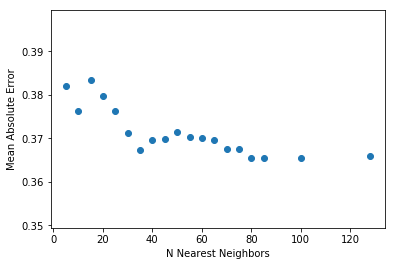

In [46]:
plt.scatter(x=n_users_list, y=mae_list)
plt.xlabel("N Nearest Neighbors")
plt.ylabel("Mean Absolute Error")
plt.show()

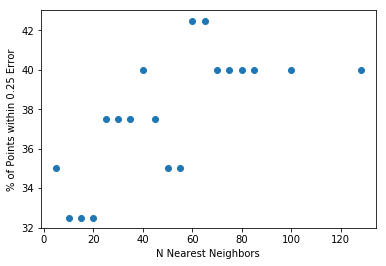

In [47]:
plt.scatter(x=n_users_list, y=quarter_abs_error_list)
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Points within 0.25 Error")
plt.show()

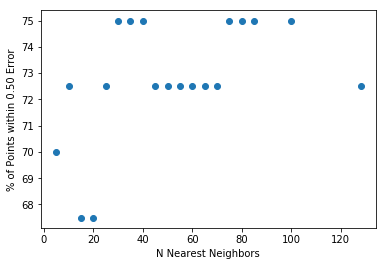

In [48]:
plt.scatter(x=n_users_list, y=half_abs_error_list)
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Points within 0.50 Error")
plt.show()

#### LinearSVR, Search for C, Search for Epsilon

In [52]:
C_space = [0.1, 0.25, 0.5, 0.75, 1.0]
epsilon_space = [0.25/2, 0.25, 0.5]

In [100]:
# %%time

# mae_list = []
# quarter_abs_error_list = []
# half_abs_error_list = []

# for top_n in n_users_list:
    
#     # split data 
#     df_top_n = df[df['nearest_neighbor_rank'] <= top_n]
#     X_train = df_top_n[features]
#     y_train = df_top_n[target]
    
#     X_test = df[df['username'] == user_of_reference][features]
#     y_test = df[df['username'] == user_of_reference][target]

#     # train
#     from sklearn.svm import LinearSVR
#     from sklearn.model_selection import GridSearchCV
#     grid = {'C': C_space,
#             'epsilon': epsilon_space,
#             'fit_intercept': [False],
#             'loss': ['epsilon_insensitive'],
#             'random_state':[rand_state],
#             'max_iter':[100000]}
#     svr = LinearSVR()
#     model = GridSearchCV(svr, param_grid=grid, cv=5, scoring='neg_mean_absolute_error')
#     model.fit(X_train, y_train)

#     # Evaluate model on user's data 
#     preds = model.predict(X_test)

#     # unscale
#     preds_unscaled = y_scaler.inverse_transform(preds)
#     y_test_unscaled = y_scaler.inverse_transform(y_test)

#     # evaluate results
#     results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
#     results_df.columns = ['predicted', 'actual']
#     results_df['error'] = results_df['predicted'] - results_df['actual']
#     results_df['abs_error'] = abs(results_df['error'])

#     # Performance Metrics 
#     mae = np.mean(results_df['abs_error'])
#     print('MAE =', np.round(mae,5), "for n =", top_n, 
#           "with final params =", model.best_params_)

#     quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
#     half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
#     mae_list.append(mae)

In [101]:
# plt.scatter(x=n_users_list, y=mae_list)
# plt.xlabel("N Nearest Neighbors")
# plt.ylabel("Mean Absolute Error")
# plt.show()

In [ ]:
plt.scatter(x=n_users_list, y=quarter_abs_error_list)
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Points within 0.25 Error")
plt.show()

In [ ]:
plt.scatter(x=n_users_list, y=half_abs_error_list)
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Points within 0.50 Error")
plt.show()

### C. Take Top Nearest Neighbors w/ min_ppu

In [124]:
min_ppu = 100

In [125]:
user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
print("Num of users with min_ppu =", len(user_indices))
sub_df = df[df['username'].isin(user_indices)]

Num of users with min_ppu = 83


In [ ]:
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

for top_n in n_users_list:
    
    # split data 
    top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
    df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
    print("N = {}, # Points = {:,d}".format(top_n, len(df_top_n)))

N = 5, # Points = 3,600, with nn_ranks of 9.0
N = 10, # Points = 10,200, with nn_ranks of 15.0
N = 15, # Points = 14,625, with nn_ranks of 20.0
N = 20, # Points = 24,900, with nn_ranks of 25.0
N = 25, # Points = 31,914, with nn_ranks of 32.0
N = 30, # Points = 38,085, with nn_ranks of 38.0
N = 35, # Points = 47,284, with nn_ranks of 43.0
N = 40, # Points = 54,859, with nn_ranks of 48.0
N = 45, # Points = 59,009, with nn_ranks of 53.0
N = 50, # Points = 62,272, with nn_ranks of 58.0
N = 55, # Points = 71,172, with nn_ranks of 63.0
N = 60, # Points = 77,847, with nn_ranks of 68.0
N = 65, # Points = 89,147, with nn_ranks of 73.0
N = 70, # Points = 95,747, with nn_ranks of 78.0


In [ ]:
list(sub_df['nearest_neighbor_rank'].unique())[:top_n]

#### ElasticNet, Search for Alpha, Search for L1 Ratio

In [52]:
l1_ratio_space = [.1, .5, .7, .9, .95, .99, 1]

In [53]:
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]

In [54]:
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

In [36]:
%%time

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]

        X_test = df[df['username'] == user_of_reference][features]
        y_test = df[df['username'] == user_of_reference][target]

        # train
        from sklearn.linear_model import ElasticNetCV
        model = ElasticNetCV(fit_intercept=False, normalize=False, l1_ratio=l1_ratio_space, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.38198 with % within 0.25 35.0 and % within 0.5 70.0 for n = 5 with alpha = 0.07629 and l1 ratio =  0.5
MAE = 0.37636 with % within 0.25 32.5 and % within 0.5 72.5 for n = 10 with alpha = 0.08173 and l1 ratio =  0.1
MAE = 0.38338 with % within 0.25 32.5 and % within 0.5 67.5 for n = 15 with alpha = 0.06488 and l1 ratio =  0.1
MAE = 0.37967 with % within 0.25 32.5 and % within 0.5 67.5 for n = 20 with alpha = 0.07635 and l1 ratio =  0.1
MAE = 0.37628 with % within 0.25 37.5 and % within 0.5 72.5 for n = 25 with alpha = 0.05659 and l1 ratio =  0.1
MAE = 0.37132 with % within 0.25 37.5 and % within 0.5 75.0 for n = 30 with alpha = 0.05086 and l1 ratio =  0.1
MAE = 0.3674 with % within 0.25 37.5 and % within 0.5 75.0 for n = 35 with alpha = 0.04258 and l1 ratio =  0.1
MAE = 0.36964 with % within 0.25 40.0 and % within 0.5 75.0 for n = 40 with alpha = 0.03212 and l1 ratio =  0.1
MAE = 0.36981 with % within 0.25 37.5 and % within 0.5 72.5 for n = 45 with alpha = 0.03387 and l1 ratio

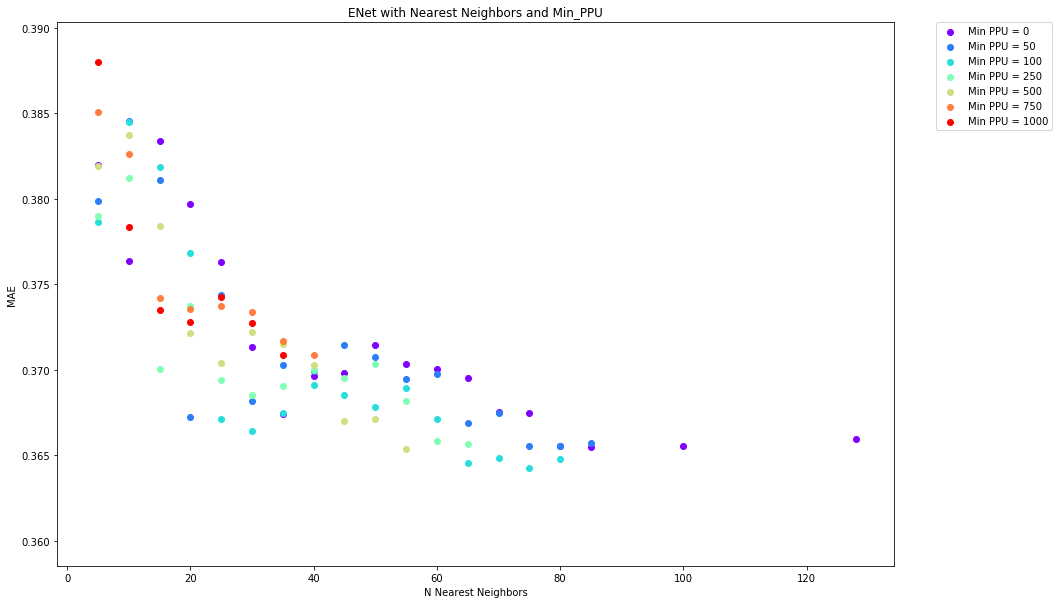

In [139]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

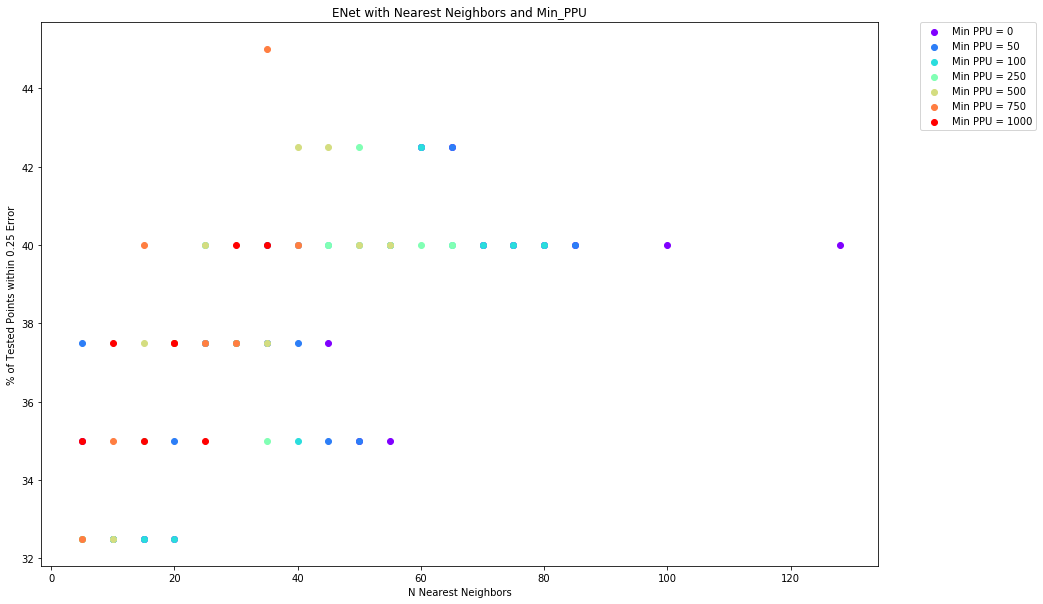

In [140]:
ls = quarter_abs_error_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Tested Points within 0.25 Error")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

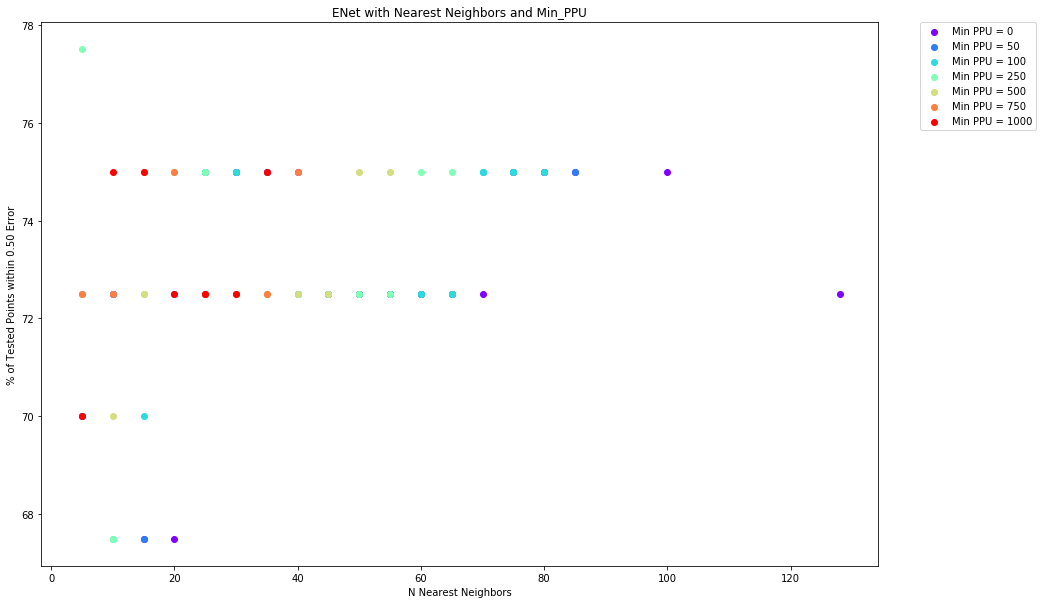

In [141]:
ls = half_abs_error_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("% of Tested Points within 0.50 Error")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [50]:
### IBU as float 

In [55]:
%%time

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]

        X_test = df[df['username'] == user_of_reference][features]
        y_test = df[df['username'] == user_of_reference][target]

        # train
        from sklearn.linear_model import ElasticNetCV
        model = ElasticNetCV(fit_intercept=False, normalize=False, l1_ratio=l1_ratio_space, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.38198 with % within 0.25 35.0 and % within 0.5 70.0 for n = 5 with alpha = 0.07629 and l1 ratio =  0.5
MAE = 0.37636 with % within 0.25 32.5 and % within 0.5 72.5 for n = 10 with alpha = 0.08173 and l1 ratio =  0.1
MAE = 0.38338 with % within 0.25 32.5 and % within 0.5 67.5 for n = 15 with alpha = 0.06488 and l1 ratio =  0.1
MAE = 0.37967 with % within 0.25 32.5 and % within 0.5 67.5 for n = 20 with alpha = 0.07635 and l1 ratio =  0.1
MAE = 0.37628 with % within 0.25 37.5 and % within 0.5 72.5 for n = 25 with alpha = 0.05659 and l1 ratio =  0.1
MAE = 0.37132 with % within 0.25 37.5 and % within 0.5 75.0 for n = 30 with alpha = 0.05086 and l1 ratio =  0.1
MAE = 0.3674 with % within 0.25 37.5 and % within 0.5 75.0 for n = 35 with alpha = 0.04258 and l1 ratio =  0.1
MAE = 0.36964 with % within 0.25 40.0 and % within 0.5 75.0 for n = 40 with alpha = 0.03212 and l1 ratio =  0.1
MAE = 0.36981 with % within 0.25 37.5 and % within 0.5 72.5 for n = 45 with alpha = 0.03387 and l1 ratio

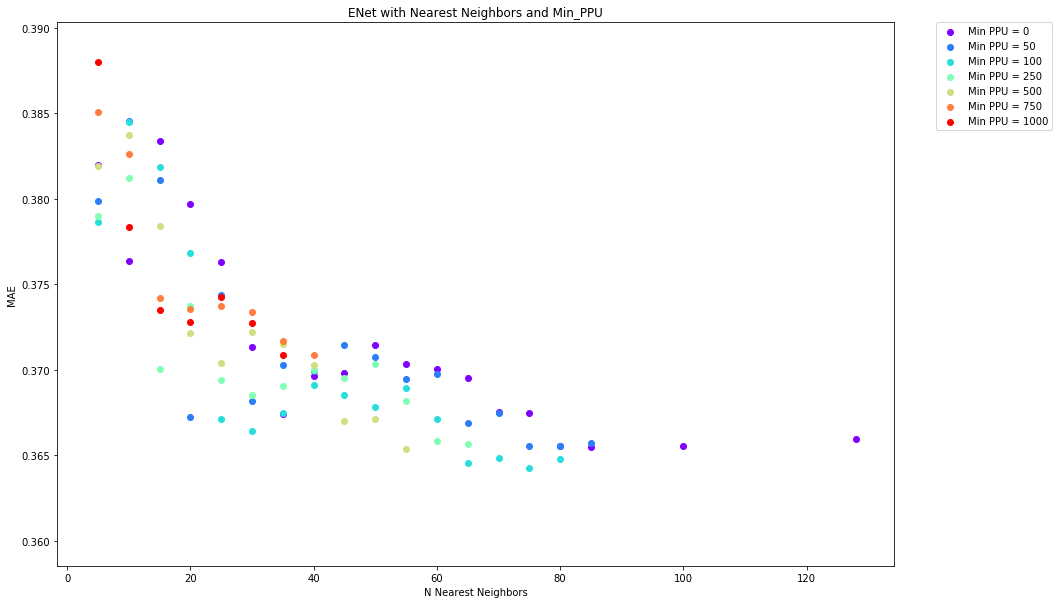

In [56]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Set Up Estimators and Grids

In [ ]:
# empty estimator dictionary
estimator_dict = {}


# import GridSearchCV and desired estimators
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR


# create models and grids 
estimator = Lasso()
grid = {
    'fit_intercept': [False],
    'normalize': [False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


estimator = ElasticNet()
grid = {
    'fit_intercept': [False],
    'normalize': [False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


# estimator = SVR()
# grid = {
#     'epsilon': np.linspace(0.25/2, 0.5, 10),
#     'C': np.linspace(1.0, 10, 10),
#     'fit_intercept': [True, False],
#     'max_iter': [10000]
# }

estimator_dict['linearsvr'] = {'estimator':estimator, 'grid':grid}

####  Set Scoring Metric

In [ ]:
scoring = 'neg_mean_absolute_error'

#### Train/Test Function

In [ ]:
def multiple_gridsearchCV(estimator_dict, X_train, y_train):
    
    # grid search for each estimator, store best params and scores for each estimator
    for key in estimator_dict.keys():
        
        # build gridsearchcv
        gridsearchcv = GridSearchCV(estimator = estimator_dict[key]['estimator'], 
                                    param_grid = estimator_dict[key]['grid'],
                                    cv=3, scoring=scoring, return_train_score=True, iid=True)

        # silence SVR convergence warnings 
        import warnings
        warnings.filterwarnings('ignore', 'Liblinear failed to converge,*')

        # fit gridsearchcv
        gridsearchcv.fit(X_train, y_train)

        # gather results 
        estimator_dict[key]['nearest_neighbors'] = 'ALL'
        estimator_dict[key]['n_training_points'] = len(X_train)
        estimator_dict[key]['best_params'] = gridsearchcv.best_params_
        estimator_dict[key][scoring] = gridsearchcv.best_score_
        estimator_dict[key]['stdev'] = gridsearchcv.cv_results_['std_test_score'][gridsearchcv.best_index_]
        
        results_dict = estimator_dict

    return(results_dict)